решение задачи базовым методом - CCM 



In [3]:
# !pip install pyEDM 
# !pip install torchcde  # пока что нужно только для получения интерполяции данных
# !pip install torchdiffeq   # для Neural ODE
# !pip install gdown  # чтобы скачать данные с гугл диска

import torchcde as cde
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy.random as npr
import pandas as pd
import pyEDM   # реализация CCM

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.4/222.4 KB 16.7 MB/s eta 0:00:00


# подготовка данных

Методы будут исследованы на двух датасетах - игрушечном и реальном

Игрушечный датасет состоит из пар временных рядов, которые зависят друг от друга:

$$X(t + 1) = X(t)[r_x - r_x X_t - \beta_{x,y}Y_t]$$
$$Y(t + 1) = Y(t)[r_y - r_y Y_t - \beta_{y,x}X_t]$$

Зависимость взята из статьи о CCM, как пример зависимости с которой CCM справляется лучше чем другие методы.

Реальные данные - данные с акселерометра и гироскопа телефона при выполнении действий.


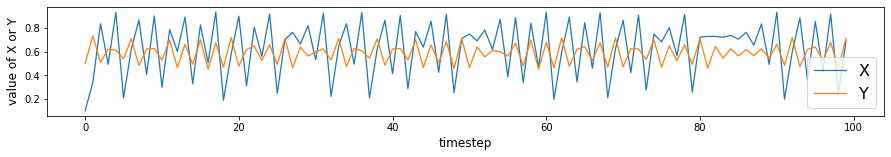

In [6]:
#  toy dataset
def generate(A, B, r, beta):
    return A*(r - r*A - beta * B)

t = 1000 # time steps
r_x =  3.8
r_y =  3.

B_xy = 0.06 # effect on x given y (effect of y on x)
B_yx = 0.3  # effect on y given x (effect of x on y)

X0 = 0.1
Y0 = 0.5

X = [X0]
Y = [Y0]
for i in range(t):
    X_ = generate(X[-1], Y[-1], r_x, B_xy)
    Y_ = generate(Y[-1], X[-1], r_y, B_yx)    
    X.append(X_)
    Y.append(Y_)  

X_toy = np.array(X).T
Y_toy = np.array(Y).T

X_toy =pd.DataFrame(np.array([np.arange(0, len(X_toy)), X_toy]).T, columns=["time", "x"])
Y_toy =pd.DataFrame(np.array([np.arange(0, len(Y_toy)), Y_toy]).T, columns=["time", "y"])

plt.figure(figsize=(15,2))
max_t = 100
plt.plot(X_toy['x'][:max_t], linewidth=1.25, label='X')
plt.plot(Y_toy['y'][:max_t], linewidth=1.25, label='Y')
plt.xlabel('timestep', size=12)
plt.ylabel('value of X or Y', size=12)
plt.legend(prop={'size': 16})

In [146]:
## пусть пока стоит
# import subprocess
# import os
# import pathlib
# path = "./drive/MyDrive/'Colab Notebooks'/m1p/datasets/"
# # os.chdir(path)
# files = list(map(lambda x:str(x),range(4, 12) ))
# if os.path.exists('unzipped'):
#     !rm -r unzipped
# if not os.path.exists('unzipped'):
#     os.mkdir('unzipped')
#     for file in files:
#         os.mkdir(f"unzipped/{file}")
#         filename = f"{file}.zip"
#         dest_name = f"unzipped/{file}"
#         subprocess.run(["unzip", filename, "-d", dest_name])
# !zip -r zip_data.zip unzipped

In [7]:
#  zip file link
# https://drive.google.com/file/d/1IFgOpn0MF8EP0W4jsaOWKYLCx0spsu1W/view?usp=sharing
# !pip install gdown
import gdown
url = 'https://drive.google.com/uc?id=1IFgOpn0MF8EP0W4jsaOWKYLCx0spsu1W'
output = 'dataset.zip'
gdown.download(url, output, quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1IFgOpn0MF8EP0W4jsaOWKYLCx0spsu1W
To: /content/dataset.zip
100%|██████████| 4.00M/4.00M [00:00<00:00, 191MB/s]


Archive:  dataset.zip
   creating: unzipped/
   creating: unzipped/4/
  inflating: unzipped/4/Accelerometer.csv  
  inflating: unzipped/4/Gyroscope.csv  
 extracting: unzipped/4/Annotation.csv  
  inflating: unzipped/4/TotalAcceleration.csv  
  inflating: unzipped/4/GyroscopeUncalibrated.csv  
  inflating: unzipped/4/AccelerometerUncalibrated.csv  
  inflating: unzipped/4/Metadata.csv  
   creating: unzipped/5/
  inflating: unzipped/5/Metadata.csv  
  inflating: unzipped/5/Accelerometer.csv  
  inflating: unzipped/5/Gyroscope.csv  
 extracting: unzipped/5/Annotation.csv  
  inflating: unzipped/5/TotalAcceleration.csv  
  inflating: unzipped/5/GyroscopeUncalibrated.csv  
  inflating: unzipped/5/AccelerometerUncalibrated.csv  
   creating: unzipped/6/
  inflating: unzipped/6/Accelerometer.csv  
  inflating: unzipped/6/Metadata.csv  
  inflating: unzipped/6/Gyroscope.csv  
 extracting: unzipped/6/Annotation.csv  
  inflating: unzipped/6/TotalAcceleration.csv  
  inflating: unzipped/6/Gyro

In [8]:
# так как метод непараметрический, рассмотрим некоторый кусок из наблюдений
X_data = pd.read_csv("./unzipped/5/Accelerometer.csv")
Y_data = pd.read_csv("./unzipped/5/Gyroscope.csv")

In [9]:
X_data.head(10)

,time,seconds_elapsed,z,y,x
0,1677922465782216200,0.082216,-0.008584,-0.015052,-0.008574
1,1677922465798176800,0.098177,-0.156116,0.041154,0.126653
2,1677922465814137000,0.114137,-0.072376,0.003822,0.268500
3,1677922465830128000,0.130128,0.293719,-0.058798,0.420105
4,1677922465846088700,0.146089,0.480246,-0.094096,0.403769
5,1677922465862049000,0.162049,0.347070,0.028501,0.257218
6,1677922465878040000,0.178040,0.083957,0.127964,0.024611
7,1677922465894000400,0.194000,-0.120475,0.124660,-0.098641
8,1677922465909961000,0.209961,-0.173147,0.055228,-0.208774
9,1677922465925921300,0.225921,-0.177945,0.055655,-0.163792


In [10]:
Y_data.head(10)

,time,seconds_elapsed,z,y,x
0,1677922465778645800,0.078646,0.103236,-0.137445,0.091019
1,1677922465794179000,0.094179,0.137445,-0.072693,0.037263
2,1677922465810169900,0.110170,0.154549,-0.021380,-0.054367
3,1677922465826191400,0.126191,0.132558,0.036652,-0.100182
4,1677922465842090800,0.142091,0.059254,0.091019,-0.064141
5,1677922465858081800,0.158082,-0.024435,0.022602,0.029322
6,1677922465874042400,0.174042,-0.064752,-0.073915,0.075136
7,1677922465890033200,0.190033,-0.064752,-0.131336,0.073304
8,1677922465906024200,0.206024,-0.025045,-0.123395,0.042761
9,1677922465921954000,0.221954,0.023824,-0.058032,0.009774


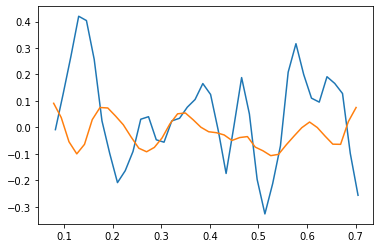

In [26]:
plt.plot(X_data['seconds_elapsed'][:40], X_data['x'][:40])
plt.plot(Y_data['seconds_elapsed'][:40], Y_data['x'][:40])

Так как данные сняты со сдвигом (на устройстве приложения не могут записать время в один и тот же момент) нужно ввести структуру для получения измерений с одинаковым временем

Рассмотрим линейную и кубическую интерполяцию для решения этой проблемы

In [121]:
def get_interpolation(data, linear = True):
    data_times = torch.tensor(np.array(data["seconds_elapsed"]))
    data_linear = torch.tensor(np.array(data[["x", "y", "z"]]))
    if linear:
        data_coeffs = cde.linear_interpolation_coeffs(data_linear, data_times)
        data_interploation = cde.LinearInterpolation(data_coeffs, data_times)
    else:  # else we use qubic interpolation
        data_coeffs = cde.natural_cubic_spline_coeffs(data_linear, data_times)
        data_interploation = cde.CubicSpline(data_coeffs, data_times)
    return data_interploation

def align_by_time(X_data, Y_data, t = None, linear = True):
    X_interpolation = get_interpolation(X_data, linear)
    Y_interpolation = get_interpolation(Y_data, linear)
    if t is None:
        t = X_interpolation.grid_points
    align_x = torch.vstack([X_interpolation.evaluate(t_i) for t_i in t])
    align_y = torch.vstack([Y_interpolation.evaluate(t_i) for t_i in t])
    rez = torch.hstack([t.reshape(-1, 1), align_x, align_y]).numpy()
    rez = pd.DataFrame(rez, columns = ["time", "A:x", "A:y", "A:z", "G:x", "G:y", "G:z"])
    return rez

real_data = align_by_time(X_data, Y_data)

torch.Size([2837]) torch.Size([2837, 3]) torch.Size([2837, 3])


"time", "A:x", "A:y", "A:z", "G:x", "G:y", "G:z"

здесь A:  --- акселерометр

G: --- гироскоп

In [123]:
real_data.head()

,time,A:x,A:y,A:z,G:x,G:y,G:z
0,0.082216,-0.008574,-0.015052,-0.008584,0.078662,-0.122560,0.111100
1,0.098177,0.126653,0.041154,-0.156116,0.014355,-0.059865,0.141721
2,0.114137,0.268500,0.003822,-0.072376,-0.065712,-0.007010,0.149103
3,0.130128,0.420105,-0.058798,0.293719,-0.091258,0.050113,0.114407
4,0.146089,0.403769,-0.094096,0.480246,-0.040775,0.073914,0.038331


# обработка

## toy dataset

сначала выясним, какая размерность скрытого пространства оптимальна для этой пары рядов:

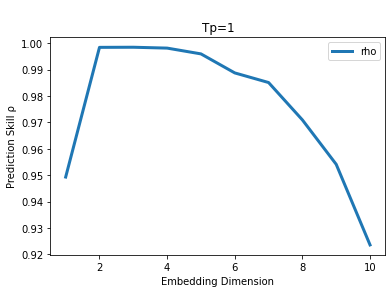

In [81]:
# toy dataset
rhos = pyEDM.EmbedDimension(dataFrame = Y_toy, lib = "1, 200", pred = "201 300", columns = 'y')

Видим, что максимальная предсказательная способность достигается при использовании размерности погружения = 2

Так же видим, что при увеличении размерности Embedding предсказательная способность падает. Это говорит о нелинейности данных

Посмотрим, какая размерность нужна для предсказания X_toy

как мы помним он слабо зависит от Y, то есть он больше автокоррелирован чем Y

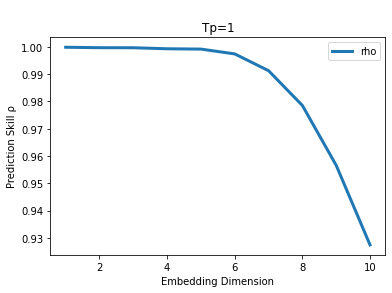

In [83]:
rhos = pyEDM.EmbedDimension(dataFrame = X_toy, lib = "1, 200", pred = "201 300", columns = 'x')

видно что для размерности скрытого слоя = 1 достаточно для предсказания X_toy

Рассмотрим теперь, на каком интервале предсказания Y_toy b X_toy не портятся:

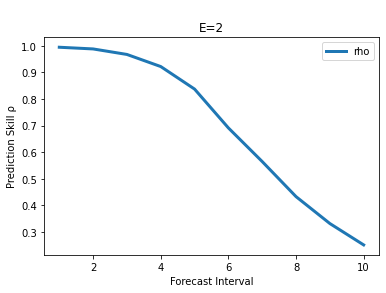

In [85]:
# Y_toy
tmp = pyEDM.PredictInterval(dataFrame=Y_toy, lib = "1, 100", pred = "251 500", columns='y', E = 2,)

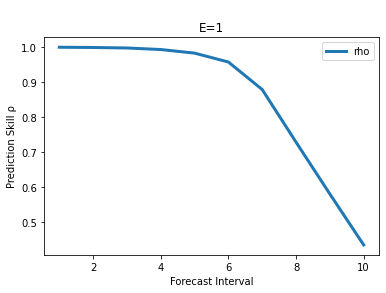

In [93]:
# Y_toy
tmp = pyEDM.PredictInterval(dataFrame=X_toy, lib = "1, 100", pred = "251 500", columns='x', E = 1)

-> предсказания X_toy устойчивы на бОльшем интервале чем Y_toy

Покажем, что ряды зависят друг от друга:

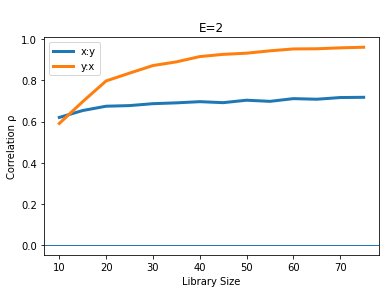

In [96]:
toy_data = pd.merge(X_toy, Y_toy, on = "time" )
tmp = pyEDM.CCM(dataFrame= toy_data, E = 2, columns= 'x', target = 'y', libSizes="10 75 5", sample = 100, showPlot = True)

для сравнения CCM для двух независимых случайных рядов:

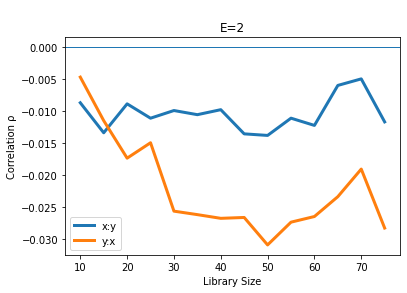

In [97]:
data_random = pd.DataFrame( np. array( [np.arange(500), np.random.randn(500), np.random.randn(500)]).T , columns=["time", 'x', 'y'])
tmp = pyEDM.CCM(dataFrame= data_random, E = 2, columns= 'x', target = 'y', libSizes="10 75 5", sample = 100, showPlot = True)

Корреляции принимают малые значения по сравнению с toy dataset

## real dataset

Найдем оптимальную размерность скрытого пространства:

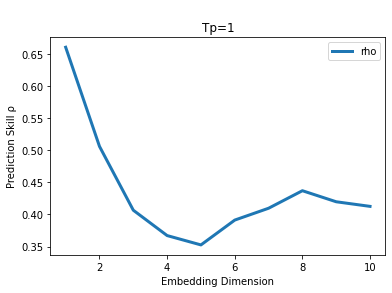

In [124]:
rhos = pyEDM.EmbedDimension(dataFrame = real_data, lib = "1, 200", pred = "201 300", columns = 'A:x A:y A:z')

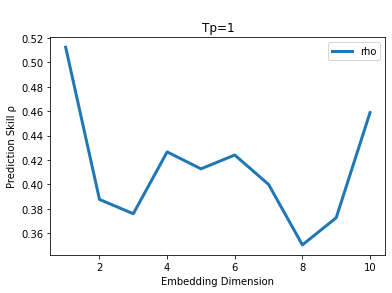

In [125]:
rhos = pyEDM.EmbedDimension(dataFrame = real_data, lib = "1, 200", pred = "201 300", columns = 'G:x G:y G:z')

Как видно, данные акселерометра предсказываются хуже, потому что поток  его данных не инертный: измеряется ускорение, которое может меняться скачками)

Теперь посмотрим, насколько долго можно предсказывать ряды, используя только их самих. Используется симплексный метод 

Акселерометр:

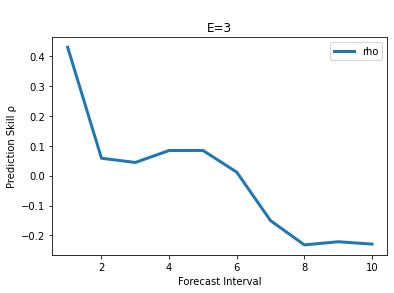

In [126]:
tmp = pyEDM.PredictInterval(dataFrame=real_data, lib = "1, 100", pred = "251 500", columns = 'A:x A:y A:z', E = 3,)

Гироскоп:

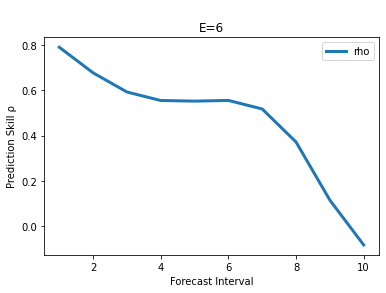

In [129]:
tmp = pyEDM.PredictInterval(dataFrame = real_data, lib = "1, 100", pred = "251 500", columns='G:x G:y G:z', E = 6,)

Гироскоп можно более точно предсказывать

это объясняется тем, что данные гироскопа инерционны, а акселерометр считает мгновенное ускорение, которое может меняться мгновенно( в нашем приближении)

Теперь выясним, зависят ли ряды друг от друга 

проверка взаимодействия A:x с G:x

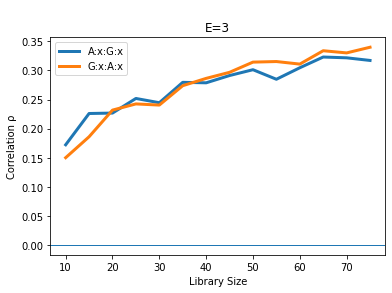

In [142]:
tmp = pyEDM.CCM(dataFrame= real_data.iloc[:1000], E = 3, columns= 'A:x', target = 'G:x', libSizes="10 75 5", sample = 100, showPlot = True)

проверка взаимодействия A:y с G:y

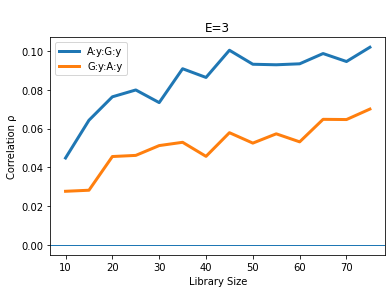

In [143]:
tmp = pyEDM.CCM(dataFrame= real_data.iloc[:1000], E = 3, columns= 'A:y', target = 'G:y', libSizes="10 75 5", sample = 100, showPlot = True)

Проверка взаимодействия A:x с G:y и с G:z

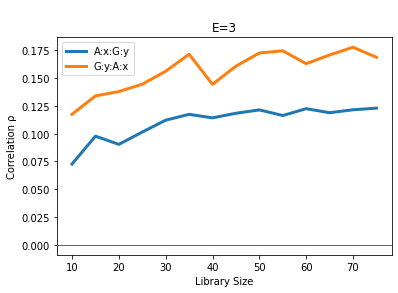

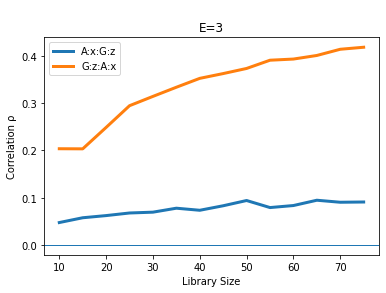

In [145]:
tmp = pyEDM.CCM(dataFrame= real_data.iloc[:1000], E = 3, columns= 'A:x', target = 'G:y', libSizes="10 75 5", sample = 100, showPlot = True)
tmp = pyEDM.CCM(dataFrame= real_data.iloc[:1000], E = 3, columns= 'A:x', target = 'G:z', libSizes="10 75 5", sample = 100, showPlot = True)

Можно увидеть, что везде положительные корреляции, поэтому возможно что ряды зависят

Дальнейшая работа будет заключаться в том, чтобы строить скрытые состояния, в которых корреляция будет бОльшей